In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import pmdarima as pmd
import itertools 
from statsmodels.tsa.stattools import adfuller, acf, pacf,kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
warnings.filterwarnings("ignore")

In [2]:
FILE_PATH = './BTC_factors/addresses/BTC_1h_profit_relative.csv'
TARGET_COL = 'profit_relative'
df = pd.read_csv(FILE_PATH)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')
cutoff_date = pd.to_datetime('2021-01-01')
df = df[df['datetime'] >= cutoff_date].copy()
df.set_index('datetime', inplace=True)
data = df[TARGET_COL].resample('1D').mean().dropna()
data = data.to_frame(name='y') 
n_obs = len(data)
train_size = int(0.8 * n_obs)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]
print(train_data.tail())


                   y
datetime            
2024-07-14  0.857433
2024-07-15  0.884141
2024-07-16  0.911753
2024-07-17  0.928394
2024-07-18  0.919675


In [3]:
def plot_time_series_analysis(ts, lags=40, title_prefix='Time Series Analysis'):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'{title_prefix}', fontsize=18)
    
    # 1. Original Time Series
    axes[0, 0].plot(ts)
    axes[0, 0].set_title('1. Original Time Series', fontsize=14)
    axes[0, 0].set_xlabel('Time Index')
    axes[0, 0].set_ylabel('Value')
    axes[0, 0].grid(True, linestyle='--', alpha=0.6)

    # 2. Distribution (Histogram + KDE)
    sns.histplot(ts, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('2. Distribution (Histogram & KDE)', fontsize=14)
    axes[0, 1].set_xlabel('Value')
    axes[0, 1].set_ylabel('Frequency')

    # 3. ACF
    plot_acf(ts, lags=lags, ax=axes[1, 0], title='3. ACF')
    axes[1, 0].set_xlabel('Lags')
    axes[1, 0].set_ylabel('ACF')

    # 4. PACF
    plot_pacf(ts, lags=lags, ax=axes[1, 1], method='ywm', title='4. PACF')
    axes[1, 1].set_xlabel('Lags')
    axes[1, 1].set_ylabel('PACF')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def run_stationarity_tests(timeseries, alpha=0.05):
    results = {}

    # ADF Test (H0: non-stationary)
    adf_result = adfuller(timeseries, autolag='AIC')
    adf_statistic = adf_result[0]
    adf_p_value = adf_result[1]

    if adf_p_value <= alpha:
        adf_conclusion = "Stationary"
        is_adf_stationary = True
    else:
        adf_conclusion = "Non-stationary"
        is_adf_stationary = False

    results['ADF'] = {
        'Test': 'ADF',
        'H0': 'Non-stationary (unit root exists)',
        'Statistic': f'{adf_statistic:.6f}',
        'p-value': f'{adf_p_value:.6f}',
        'Critical Values': adf_result[4],
        'Lags Used': adf_result[2],
        'Conclusion': adf_conclusion
    }

    # KPSS Test (H0: stationary)
    kpss_stat, kpss_p_value, kpss_lags, kpss_critical_values = kpss(timeseries, regression='c', nlags='auto')

    if kpss_p_value <= alpha:
        kpss_conclusion = "Non-stationary"
        is_kpss_stationary = False
    else:
        kpss_conclusion = "Stationary"
        is_kpss_stationary = True

    results['KPSS'] = {
        'Test': 'KPSS',
        'H0': 'Stationary',
        'Statistic': f'{kpss_stat:.6f}',
        'p-value': f'{kpss_p_value:.6f}',
        'Critical Values': kpss_critical_values,
        'Lags Used': kpss_lags,
        'Conclusion': kpss_conclusion
    }

    # Combined conclusion
    if is_adf_stationary and is_kpss_stationary:
        overall_conclusion = "Strong evidence: Stationary"
    elif (not is_adf_stationary) and (not is_kpss_stationary):
        overall_conclusion = "Strong evidence: Non-stationary"
    elif is_adf_stationary and (not is_kpss_stationary):
        overall_conclusion = "Conflicting: Possibly trend-stationary"
    else:
        overall_conclusion = "Conflicting: Stationarity not supported"

    results['Overall_Conclusion'] = overall_conclusion
    return results


def print_stationarity_results(results_dict):
    print("=" * 60)
    print(f"Time Series Stationarity Report (α = 0.05)")
    print("=" * 60)

    adf = results_dict['ADF']
    print("### 1. ADF Test ###")
    print(f"  H0: {adf['H0']}")
    print(f"  Statistic: {adf['Statistic']}")
    print(f"  p-value: {adf['p-value']}")
    print(f"  Critical Values:")
    for key, value in adf['Critical Values'].items():
        print(f"    {key} ({value:.4f})")
    print(f"  Conclusion: {adf['Conclusion']}\n")

    kpss = results_dict['KPSS']
    print("### 2. KPSS Test ###")
    print(f"  H0: {kpss['H0']}")
    print(f"  Statistic: {kpss['Statistic']}")
    print(f"  p-value: {kpss['p-value']}")
    print(f"  Critical Values:")
    for key, value in kpss['Critical Values'].items():
        print(f"    {key} ({value:.4f})")
    print(f"  Conclusion: {kpss['Conclusion']}\n")

    print("-" * 60)
    print(f"Overall Judgment: {results_dict['Overall_Conclusion']}")
    print("-" * 60)


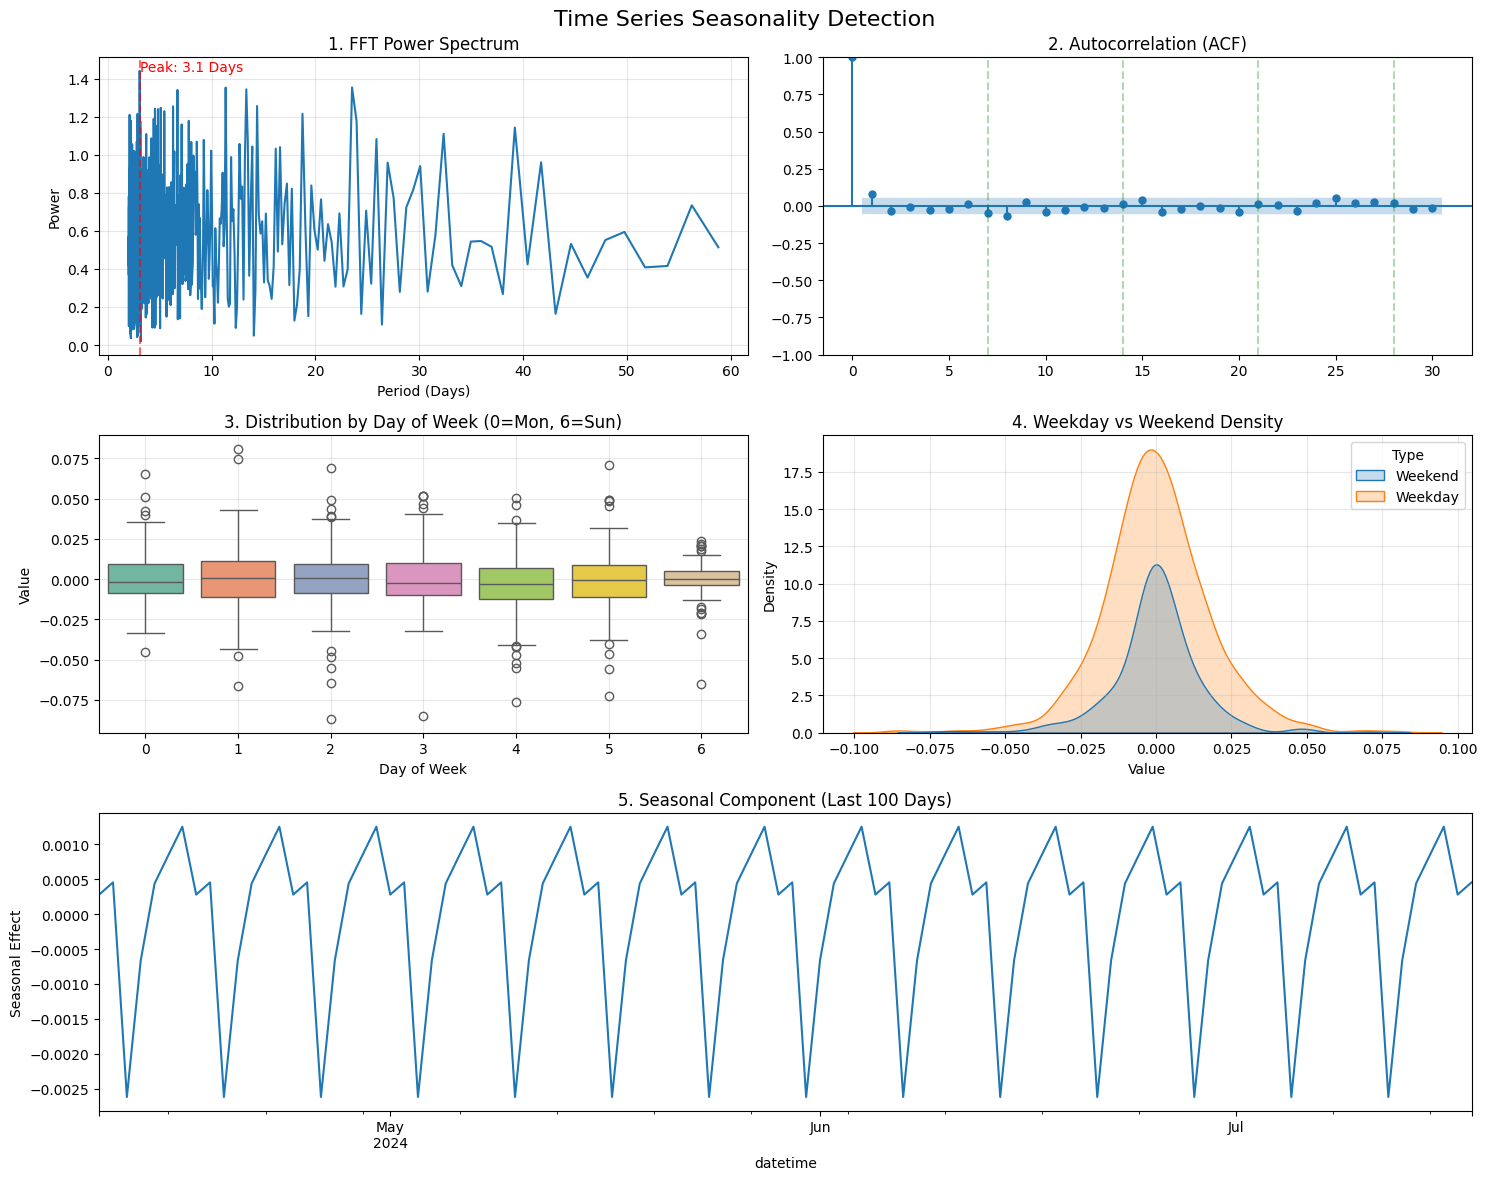

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.fft import fft, fftfreq

def analyze_seasonality(data: pd.Series, max_lag=30):
    """
    Comprehensive seasonal pattern detection for time series.
    :param data: Pandas Series (DatetimeIndex required)
    :param max_lag: max lag for ACF test
    """

    data = data.dropna()

    fig = plt.figure(figsize=(15, 12))
    plt.suptitle('Time Series Seasonality Detection', fontsize=16)

    # ==============================
    # 1. FFT (Frequency domain)
    # ==============================
    ax1 = plt.subplot(3, 2, 1)
    detrended = data - data.mean()
    n = len(detrended)

    yf = fft(detrended.values)
    xf = fftfreq(n, 1)
    yf = np.abs(yf[:n//2])
    xf = xf[:n//2]

    with np.errstate(divide='ignore'):
        periods = 1 / xf

    mask = (periods >= 2) & (periods <= 60)
    ax1.plot(periods[mask], yf[mask])
    ax1.set_title('1. FFT Power Spectrum')
    ax1.set_xlabel('Period (Days)')
    ax1.set_ylabel('Power')
    ax1.grid(alpha=0.3)

    if len(yf[mask]) > 0:
        peak_idx = np.argmax(yf[mask])
        peak_period = periods[mask][peak_idx]
        ax1.axvline(x=peak_period, color='r', linestyle='--', alpha=0.6)
        ax1.text(peak_period, max(yf[mask]), f'Peak: {peak_period:.1f} Days', color='r')

    # ==============================
    # 2. ACF (Time domain)
    # ==============================
    ax2 = plt.subplot(3, 2, 2)
    plot_acf(data, lags=max_lag, ax=ax2, title='2. Autocorrelation (ACF)')
    for lag in [7, 14, 21, 28]:
        if lag <= max_lag:
            ax2.axvline(x=lag, color='green', linestyle='--', alpha=0.3)

    # ==============================
    # 3. Distribution by Day of Week
    # ==============================
    ax3 = plt.subplot(3, 2, 3)
    df_viz = data.to_frame(name='Value')
    df_viz['DayOfWeek'] = df_viz.index.dayofweek
    df_viz['Type'] = df_viz['DayOfWeek'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

    sns.boxplot(data=df_viz, x='DayOfWeek', y='Value', ax=ax3, palette="Set2")
    ax3.set_title('3. Distribution by Day of Week (0=Mon, 6=Sun)')
    ax3.set_xlabel('Day of Week')
    ax3.grid(alpha=0.3)

    # ==============================
    # 4. Weekday vs Weekend Density
    # ==============================
    ax4 = plt.subplot(3, 2, 4)
    sns.kdeplot(data=df_viz, x='Value', hue='Type', fill=True, ax=ax4)
    ax4.set_title('4. Weekday vs Weekend Density')
    ax4.grid(alpha=0.3)

    # ==============================
    # 5. Seasonal Decomposition (period=7)
    # ==============================
    ax5 = plt.subplot(3, 1, 3)
    try:
        res = seasonal_decompose(data, model='additive', period=7)
        res.seasonal.iloc[-100:].plot(ax=ax5)
        ax5.set_title('5. Seasonal Component (Last 100 Days)')
        ax5.set_ylabel('Seasonal Effect')
    except Exception as e:
        ax5.text(0.5, 0.5, f'Decomposition Failed: {str(e)}', ha='center')

    plt.tight_layout()
    plt.show()
analyze_seasonality(train_data['y'].diff().dropna())
